## Import des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Chargement des données nettoyées

In [2]:
data_cleaned = pd.read_feather("p3_data3.ft")
data_cleaned.head(3)

C:\Users\Lebrun\Anaconda3\envs\DS_projet3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,code,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,...,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,imputed_fat_100g
0,0000000000017,Vitória crackers,None,None,None,None,None,None,None,None,...,7.8,1.40000,0.551181,NaN,NaN,NaN,NaN,NaN,NaN,False
1,0000000000031,Cacao,None,130 g,None,None,None,None,None,None,...,5.6,0.52832,0.208000,NaN,NaN,NaN,NaN,NaN,NaN,True
2,0000000000123,Sauce Sweety chili 0%,None,None,None,None,None,None,None,None,...,0.2,2.04000,0.803150,NaN,NaN,NaN,NaN,NaN,NaN,False


# Partie 1 - Visualisation par réduction dimensionnelle (t-SNE)

### Encodage de la variable 'nutrition_grade_fr' (variable catégorielle ordinale)
Nous encodons ces données afin de pouvoir afficher des étiquettes colorées avec la t-SNE.

In [3]:
feature = 'nutrition_grade_fr'

# Create mapper
scale_mapper = {"a":5,
                "b":4,
                "c":3,
                "d":2,
                "e":1,
               }

# Replace feature values with scale
data_cleaned['nutrition_grade_fr_encoded'] = data_cleaned[feature].replace(scale_mapper)

### Selection des variables pour la t-SNE

In [4]:
# Selecting all the numeric columns
subset = list(data_cleaned.select_dtypes(include=['number']).columns)

# Adding the 'nutrition_grade_fr' feature (that will be used as label)
subset.append('nutrition_grade_fr')

# Keeping only the required columns in the dataframe
X = data_cleaned[subset]

# Dropping rows with missing values (not handled by t-SNE implementation)
X = X.dropna(subset=subset)

# Dropping an outlier by position
outlier_index = 3761
X = X.drop(X.index[outlier_index])

# Defining the labels
y = X[['nutrition_grade_fr', 'nutrition_grade_fr_encoded']]

### Pré-traitement

In [5]:
# Centering and reducting (except last column: 'nutrition_grade_fr')
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler().fit(X.iloc[:,:-2])
X_std = std_scaler.transform(X.iloc[:,:-2])

### Exécution de la t-SNE

In [6]:
# Import libraries
from sklearn import manifold

# Instanciation of t-SNE
tsne = manifold.TSNE(n_components=2,
                     perplexity=30,
                     n_iter=300,
                     init='pca', # initialisation by a PCA
                     # random_state=0 # pour la reproductibilité
                    )

# Applying the t-SNE
X_projected = tsne.fit_transform(X_std) # t-SNE do not have ".transform" method

### Visualisation de la t-SNE en 2D
Nous procédons à une visualisation des données, en fonction de leur note Nutri-Score ('nutrition_grade_fr'), par t-SNE.

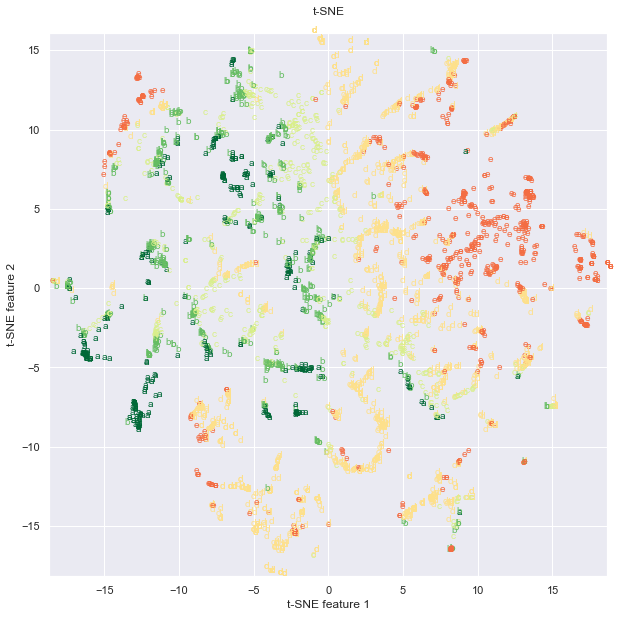

In [7]:
# Graphical representation of the population
plt.figure(figsize=(10,10))

# Definitions of axis boundaries
plt.xlim(X_projected[:,0].min(), X_projected[:,0].max())
plt.ylim(X_projected[:,1].min(), X_projected[:,1].max())

# Definition of axis'labels
plt.title("t-SNE\n")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")

# Glyphes and colors are representing 'Nutri-Score grades'
for i in range(len(X_projected)):
    plt.text(X_projected[:,0][i], # x-coordinate
             X_projected[:,1][i], # y-coordinate
             y.iloc[i,0], # labels
             color=plt.cm.RdYlGn(int(y.iloc[i,1])/5.)
    )

Nous constatons que, en lisant le graphique de gauche à droite, l'algorithme t-SNE a réussi à saisir la structure des données : les produits sont (globalement) classées par Nutri-Score. De plus, les grappes ("clusters") sont homogènes en terme de score de nutrition.

# Partie 2 - Analyses univariées

# 2.A Variable 'nutrition-score-fr_100g' (quantitative)
Nous allons étudier en détail la variable 'nutrition-score-fr_100g' qui va jouer un rôle crucial pour notre application.

### Taux de remplissage

In [8]:
def feature_filling_rate(dataframe, feature):
    """Calculate and displays the filling rate for a particular column in a pd.DataFrame."""
    
    # Count of the values on each column
    values_count = dataframe[feature].count()

    # Calculating filling rates
    nb_rows = dataframe.shape[0]
    filling_rate = values_count / nb_rows

    # Displaying and returning result
    print("The filling rate of the column '{}' is: {:.2%}".format(feature, filling_rate))
    return filling_rate

In [9]:
dataframe = data_cleaned
feature = 'nutrition-score-fr_100g'
feature_filling_rate(dataframe, feature)

The filling rate of the column 'nutrition-score-fr_100g' is: 27.38%


0.273802322610251

### Résumé statistique

In [10]:
data_cleaned['nutrition-score-fr_100g'].describe()

count    210025.000000
mean         55.366146
std          15.990228
min           0.000000
25%          43.636364
50%          52.727272
75%          69.090912
max         100.000000
Name: nutrition-score-fr_100g, dtype: float64

Nous en déduisons les principaux indicateurs statistiques pour la variable 'nutrition-score-fr_100g' :
* indicateurs de tendance centrale :
    * moyenne
    * médiane (50ème percentile)


* indicateurs de dispersion :
    * écart-type
    * étendue : max - min
    * intervalle interquartile IQR = Q3 - Q1

### Distribution statistique empirique

In [11]:
def univariate_distribution(dataframe,feature):
    """Function plotting the histogram and boxplot (as subplots) for a distribution."""
    
    # importing libraries
    import matplotlib.pyplot as plt

    # filtering non-null data
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask]
    
    # Setting the data to plot
    x=data_view[feature]
    
    # Graphical properties of the main figure
    fig = plt.figure(figsize=(20, 10))
    
    plt.suptitle("Empiric statistical distribution: " + feature, fontsize=25)
    
    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(211)
    ax1.set_ylabel("Frequency", fontsize=20)

    # Main graphical properties of the second subplot (boxplot)
    ax2 = plt.subplot(212)
    ax2.set_xlabel("Value", fontsize=20)
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    
    # plotting the plots
    ax1.hist(x, bins=21)
    ax2.boxplot(data_view[feature], showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

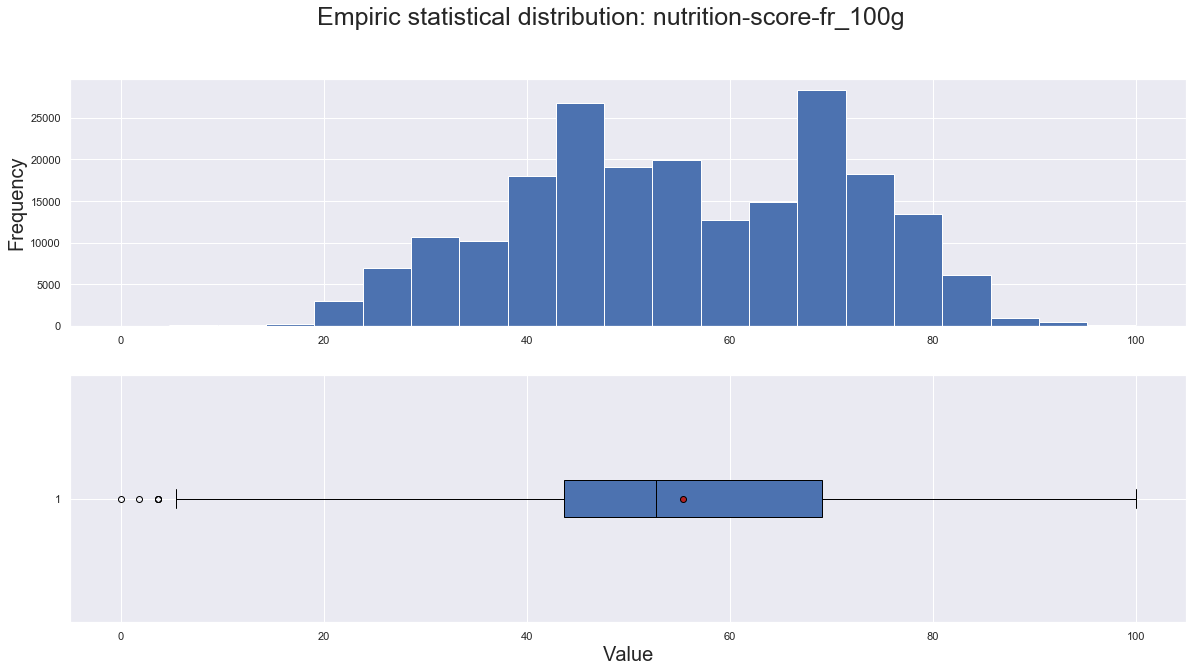

In [12]:
# Plotting the bar chart and box-plot for the statistical distribution
univariate_distribution(data_cleaned,'nutrition-score-fr_100g')

**Attention :** l'extrémité de la moustache de gauche représente la valeur minimale (min = -15) alors que l'extrémité de la moustache de droite représente la limite des "outliers" (Q3 + 1,5\*IQR). (*whiskers: the vertical lines extending to the most extreme, non-outlier data points.*)

Nous observons une distribution bimodale. En général, une distribution bimodale indique une distribution non-gaussienne. Nous allons donc effectuer des tests statistiques pour tester cette hypothèse.

## Tests de normalité

Nous allons tester la normalité de la distribution statistique. Voici le test statistique :

    H0 : les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon sont issus d'une population normalement distribuée.

    H1 :  les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon NE sont PAS issus d'une population normalement distribuée

### Test de Shapiro-Wilk

In [13]:
from scipy.stats import shapiro

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-fr_100g'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-fr_100g']

# processing the Shopiro-Wilk test
shapiro(data_nutrition_score)

C:\Users\Lebrun\Anaconda3\envs\DS_projet3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9748420119285583, 0.0)

Nous recevons un avertissement selon lequel la valeur de la p-value n'est peut-être pas correcte en raison de la trop grande taille de l'échantillon. Nous allons donc procéder à un test alternatif : le test d'Anderson-Darling pour la normalité.

### Test d'Anderson-Darling

In [14]:
from scipy.stats import anderson

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-fr_100g'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-fr_100g']

# processing the Anderson-Darling test
anderson(data_nutrition_score, dist='norm')

AndersonResult(statistic=1843.115974090906, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

La statistique de test A2 du test d'Anderson-Darling étant plus grande que la valeur critique au niveau de risque 1%, nous pouvons rejeter l'hypothèse nulle (selon laquelle les données proviennent d'une distribution normale) au risque de 1%.

### Test de Kolmogorov-Smirnov

In [15]:
from scipy.stats import kstest

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-fr_100g'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-fr_100g']

# performing the Kolmogorov-Smirnov test against normal distribution
kstest(data_nutrition_score, cdf='norm')

KstestResult(statistic=0.9999761687611887, pvalue=0.0)

La p-value du test de Kolmogorov-Smirnov étant proche de 0, nous pouvons rejeter l'hypothèse nulle (selon laquelle les données proviennent d'une distribution normale) avec un risque négligeable de se tromper.

### Test du K2 de D'Agostino

In [16]:
from scipy.stats import normaltest

# filtering non-null data for the feature
mask = data_cleaned['nutrition-score-fr_100g'].notnull()
data_view = data_cleaned[mask]
data_nutrition_score = data_view['nutrition-score-fr_100g']

# Performing D'Agostino's K2 test
stat, p = normaltest(data_nutrition_score)

# interpret
alpha = 0.05
if p > alpha:
    msg = 'Sample looks Gaussian (fail to reject H0)'
else:
    msg = 'Sample does not look Gaussian (reject H0)'
    
print(msg)

Sample does not look Gaussian (reject H0)


Tous les tests sont cohérents.

La non-normalité de la distribution de la variables est seulement gènante pour la significativité d'autres tests statistiques qui font l'hypothèse de normalité.

## Etude des valeurs hors-norme (*outliers*) pour le score de nutrition

In [17]:
def select_outliers(dataframe, feature):
    """This function return a view of dataframe with outliers.
    Outliers are those with value less than (Q1 + 1.5*IQR) or bigger than (Q3 + 1.5*IQR)"""
    
    Q1 = dataframe[feature].quantile(q=0.25, interpolation='linear')   # first quartile
    Q3 = dataframe[feature].quantile(q=0.75, interpolation='linear')   # third quartile
    IQR = Q3 - Q1                                                      # inter-quartile range
    
    # definition of mask
    mask = (dataframe[feature] < Q1 - 1.5*IQR) | (dataframe[feature] > Q3 + 1.5*IQR)
    
    # application of mask
    outliers = dataframe[mask]
    
    return outliers

In [18]:
# Selection of outliers (IQR method)
outliers = select_outliers(data_cleaned,'nutrition-score-fr_100g')

# Increase maximum number of columns to dispaly
pd.set_option("display.max_columns", 1000)

outliers

,code,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,labels,labels_tags,labels_en,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,serving_size,serving_quantity,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,main_category,main_category_en,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,imputed_fat_100g,nutrition_grade_fr_encoded
94379,0074323046199,Cajeta Quemada,Cajeta quemada espreable,660 g,Botella de plastico,botella-de-plastico,Coronado,coronado,"Lácteos, Postres, Postres lácteos, en:Productos","en:dairies,en:desserts,en:dairy-desserts,en:pr...","Dairies,Desserts,Dairy desserts,Productos",None,None,None,Walmart,"Walmart,Bodega Aurrera,Soriana,Mercado Soriana...","México,Estados Unidos","en:mexico,en:united-states","Mexico,United States","LECHE DE CABRA (57% ), GLUCOSA, AZUCAR, MALTIT...",30 g,30.0,3.0,[ leche-de-cabra -> es:leche-de-cabra ] [ 5...,"en:e202,en:e500,en:e500ii,en:e965,en:e965i","E202 - Potassium sorbate,E500 - Sodium carbona...",0.0,0.0,e,4.0,Milk and dairy products,Dairy desserts,en:dairies,Dairies,6320.0,8.330000,8.33,0.0,0.0,66.699997,46.700001,0.0,6.670000,296.00,117.000000,0.0,0.0,1.67,0.0,3.636364,38.0,False,1.0
284807,3222471981634,10 Pains au lait,10 Pains au lait,350 g,"Sachet,Plastique","sachet,plastique",Casino,casino,"Snacks, Petit-déjeuners, Snacks sucrés, Vienno...","en:snacks,en:breakfasts,en:sweet-snacks,en:vie...","Snacks,Breakfasts,Sweet snacks,Viennoiseries,M...",None,None,None,None,Casino,France,en:france,France,"Farine de _blé_ - sucre - _oeufs_ frais 10,8% ...",35g,35.0,4.0,[ farine-de-ble -> fr:farine-de-ble ] [ far...,"en:e160,en:e300,en:e417,en:e481","E160 - Carotene,E300 - Ascorbic acid,E417 - Ta...",0.0,1.0,e,4.0,sugary-snacks,pastries,en:snacks,Snacks,4260.0,34.299999,10.60,NaN,NaN,154.000000,37.099998,NaN,21.700001,3.43,1.350000,NaN,NaN,NaN,NaN,3.636364,38.0,False,1.0
453076,3596710436903,Chocolat gourmand mmm!,Chocolat en poudre,500g,"Boîte,Métal","boite,metal","Mmm !,Auchan","mmm,auchan","Boissons, Petit-déjeuners, Boissons instantané...","en:beverages,en:breakfasts,en:instant-beverage...","Beverages,Breakfasts,Instant beverages,Cocoa a...",Sans gluten,en:gluten-free,Gluten-free,France,Auchan,France,en:france,France,"Chocolat en poudre (sucre, cacao en poudre), a...",15g,15.0,0.0,[ chocolat-en-poudre -> fr:chocolat-en-poudre...,None,None,0.0,0.0,e,4.0,unknown,unknown,en:beverages,Beverages,331.0,1.900000,1.20,NaN,NaN,9.300000,9.300000,0.0,3.400000,0.14,0.055118,NaN,NaN,NaN,NaN,3.636364,38.0,False,1.0
551723,4250350518458,whey chocolat,whey chocolat,15 g,None,None,Body Attack,body-attack,"Compléments alimentaires, Compléments pour le ...","en:dietary-supplements,en:bodybuilding-supplem...","Dietary supplements,Bodybuilding supplements,P...",None,None,None,France,None,France,en:france,France,"Whey protein concentrate (89,5%), Low-fat coco...",15 g,15.0,2.0,[ whey-protein-concentrate -> fr:whey-protein...,"en:e950,en:e955","E950 - Acesulfame k,E955 - Sucralose",0.0,0.0,e,4.0,unknown,unknown,en:dietary-supplements,Dietary supplements,3570.0,21.299999,12.00,NaN,NaN,56.000000,54.000000,0.0,110.000000,2.33,0.919000,NaN,NaN,NaN,NaN,0.000000,40.0,False,1.0
614435,5420008590627,Capsules Nez-Gorge,None,None,None,None,Pranarōm,pranarōm,Compléments alimentaires,en:dietary-supplements,Dietary supplements,None,None,None,None,None,France,en:france,France,Huile végétale : Brassica napus (Colza); Marin...,None,NaN,4.0,[ huile-vegetale -> fr:huile-vegetale ] [ h...,"en:e307,en:e307c,en:e422,en:e428","E307 - Alpha-tocopherol,E307c - Tocopherol,E42...",0.0,1.0,e,3.0,unknow

Nous obtenons quelques valeurs "hors-normes" (*ouliers*). Celles-ci correspondent à des valeurs très élevées de la variable "score de nutrition". Nous constatons que certaines des données pour ces lignes sont mal renseignées, et peuvent être la cause de leur score de nutrition anormalement élevé.

Il est possible de vérifier les données à partir de la photo de la liste d'ingrédients pour éventuellement corriger.

# 2.B Variable 'nova_group' (variable catégorielle ordinale)

In [19]:
dataframe = data_cleaned
feature = 'nova_group'
feature_filling_rate(dataframe, feature)

The filling rate of the column 'nova_group' is: 34.67%


0.346685039657501

In [20]:
# Converting to integer, allowing Nan values with "I"nt
data_cleaned['nova_group'] = data_cleaned['nova_group'].astype('Int64', errors='ignore')

# Converting the dtype as ordinal categorical feature
from pandas.api.types import CategoricalDtype
data_cleaned['nova_group'] = data_cleaned['nova_group'].astype(CategoricalDtype(ordered=True))

In [21]:
data_cleaned['nova_group'].describe()

count     265931
unique         4
top            4
freq      194411
Name: nova_group, dtype: int64

In [22]:
def categorical_distribution(dataframe,feature):
    """Function plotting the bar-plot and pie-plot (as subplots) for 
    a distribution of categorical features."""
    
    # importing libraries
    import matplotlib.pyplot as plt

    # filtering non-null data for the feature
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask]
    
    # Setting the data to plot
    x=data_view[feature]
    
    # Set frequencies and labels
    labels = list(x.value_counts().sort_index().index.astype(str))
    frequencies = x.value_counts().sort_index()
    
    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))
    
    plt.suptitle("Empiric statistical distribution: " + feature, fontsize=25)
    
    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(121)
    ax1.set_xlabel("Values", fontsize=20)
    ax1.set_ylabel("Frequencies", fontsize=20)

    # Main graphical properties of the second subplot (pieplot)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Relative frequencies", fontsize=20)
    
    # plotting the plots
    ax1.bar(labels, frequencies)
    ax2.pie(frequencies,
            autopct='%1.2f%%',
            shadow=True,
              )
    
    ax2.legend(labels)
    plt.show()

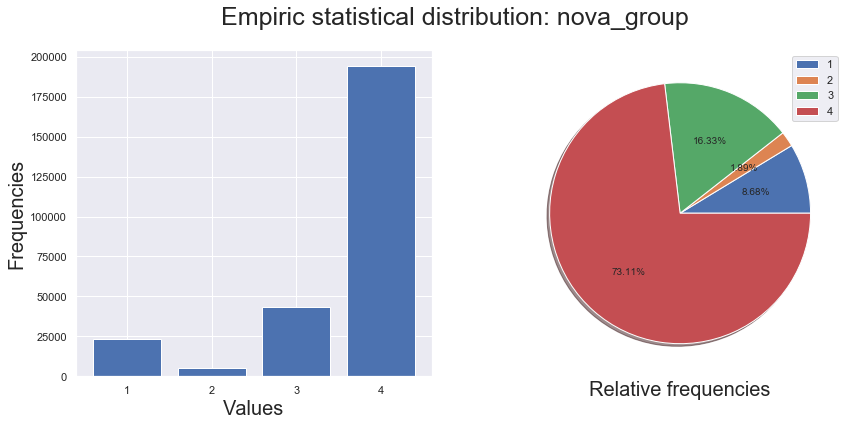

In [23]:
dataframe = data_cleaned
feature = 'nova_group'

categorical_distribution(dataframe,feature)

# 2.C Variable 'main_category' (variable catégorielle nominale)
Plusieurs variables (colonnes) semblent correspondre à la notion de catégorie :
* 'categories'
* 'categories_tags'
* 'categories_en'
* 'main_category'
* 'main_category_en'

In [24]:
dataframe[[
    'categories',
    'categories_tags',
    'categories_en',
    'main_category',
    'main_category_en',
    ]].describe()

,categories,categories_tags,categories_en,main_category,main_category_en
count,266080,266079,266079,266024,266024
unique,55142,38144,38144,6087,6087
top,Boissons,"en:beverages,en:non-alcoholic-beverages,en:uns...","Beverages,Non-Alcoholic beverages,Unsweetened ...",en:plant-based-foods-and-beverages,Plant-based foods and beverages
freq,4212,2786,2786,56682,56682


Nous constatons que certaines colonnes, bien que comportant des noms différents, semblent encoder la même information :
* 'categories_tags' et 'categories_en'
* 'main_category', 'main_category_en' et 'main_category'

In [25]:
data_cleaned["categories"].describe()

count       266080
unique       55142
top       Boissons
freq          4212
Name: categories, dtype: object

# Partie 3 - Analyses bivariées
**NB :** par "analyse bivariée", nous entendons une étude détaillée des interactions entre deux variables.

L'étude globale des corrélations entre variables sera traitée dans la partie 4 : analyses multivariées.

## 3.1 Analyse bivariée : 'nutrition_grade_fr' vs 'nutrition-score-fr_100g'
nutrition_grade_fr : nutrition grade ('a' to 'e'). see http://fr.openfoodfacts.org/score-nutritionnel-experimental-france

In [26]:
dataframe = data_cleaned
feature = 'nutrition_grade_fr'
feature_filling_rate(dataframe, feature)

The filling rate of the column 'nutrition_grade_fr' is: 27.38%


0.273802322610251

Nous constatons que le taux de remplissage de 'nutrition_grade_fr' est exactement le même que celui de 'nutrition-score-fr_100g' avant imputation. Nous supposons que la variable catégorielle 'nutrition_grade_fr' correspond à un encodage de la variable quantitative 'nutrition-score-fr_100g'.

In [27]:
mask1 = data_cleaned['nutrition_grade_fr'].notnull()
idx1 = data_cleaned[mask1].index

mask2 = data_cleaned['nutrition-score-fr_100g'].notnull()
idx2 = data_cleaned[mask2].index

idx1 ^ idx2

Int64Index([], dtype='int64')

Cette hypothèse semble confirmée par le fait que la "différence symétrique" des ensembles ayant respectivement la colonne 'nutrition_grade_fr' ou la colonne 'nutrition-score-fr_100g' complétée est nulle.

In [28]:
def modal_boxplots(dataframe, modal_feature, numerical_feature):
    '''This function return a plot of boxplots for each modality.
    Useful for bivariate analysis.'''
    
    # Creating a copy of the two features
    data_sample = dataframe[[modal_feature, numerical_feature]].copy()

    # Drop the rows where values are missing for the two features
    data_sample = data_sample.dropna(subset=[modal_feature, numerical_feature])

    # Getting the list of modalities
    modalities = data_sample[modal_feature].sort_values().unique()
    groups = []

    # Iteration on each modality
    for modality in modalities:
        # Keep only the numerical_feature for the rows (kind of a groupby)
        groups.append(data_sample[data_sample[modal_feature]==modality][numerical_feature])

    # Graphical properties   
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
                'markerfacecolor':'firebrick'}

    # Properties of the box-plot
    fig = plt.figure(figsize=(15, 6))
    plt.title(modal_feature + " vs " + numerical_feature, fontsize=20)
    plt.xlabel("Values of " + modal_feature, fontsize=15)
    plt.ylabel("Values of " + numerical_feature, fontsize=15)

    # Plotting the box-plot
    plt.boxplot(groups, labels=modalities, showfliers=False, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

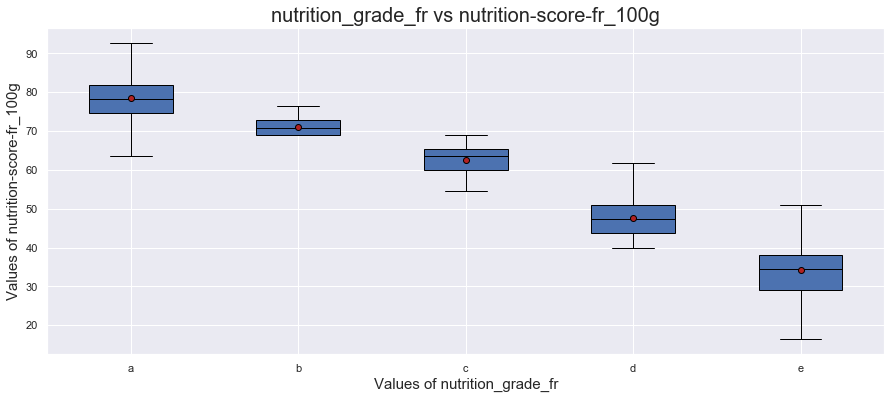

In [29]:
dataframe = data_cleaned
modal_feature = 'nutrition_grade_fr'
numerical_feature = 'nutrition-score-fr_100g'

modal_boxplots(dataframe, modal_feature, numerical_feature)

Nous pouvons constater qu'il y a quelques anomalies dans l'encodage du Nutri-Score.

Théoriquement, les diagrammes en boîtes devraient être disjoints.

## 3.2 Analyse bivariée : 'nova_score' vs 'nutrition-score-fr_100g'

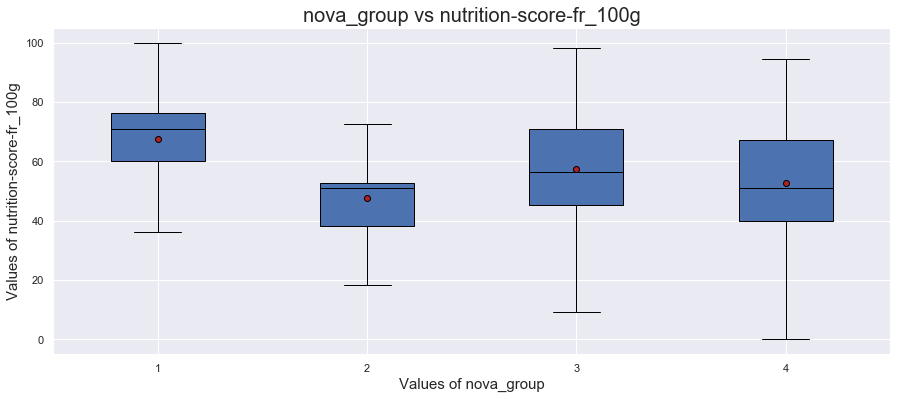

In [30]:
dataframe = data_cleaned
modal_feature = 'nova_group'
numerical_feature = 'nutrition-score-fr_100g'

modal_boxplots(dataframe, modal_feature, numerical_feature)

### Calcul du coefficient de corrélation linéaire (Pearson)

In [31]:
s1 = data_cleaned['nova_group']
s2 = data_cleaned['nutrition-score-fr_100g']

print("The Pearson linear correlation coefficient is: r = {}".format(s1.corr(s2, method='pearson')))

The Pearson linear correlation coefficient is: r = -0.28194140755642094


Nous obtenons un coefficient indiquant une corrélation négative faible entre les deux variables. Pour savoir si cette corrélation est néanmoins significative, nous allons procéder à un test statistique d'indépendance.

### Test d'indépendance du Khi-2

    H0 : les deux variables 'nova_group' et 'nutrition-score-fr_100g' sont indépendantes

    H1 : les deux variables ne sont pas indépendantes

In [32]:
# Constructing the Contingency Table
f_obs = pd.crosstab(data_cleaned['nova_group'], data_cleaned['nutrition-score-fr_100g'],margins=True)

# The Chi-Squared test for independence
from scipy import stats
results = stats.chi2_contingency(f_obs)
print("χ2 = {}\np-value = {}\ndegrees of freedom = {}".format(results[0], results[1], results[2]))

χ2 = 158615.40694581528
p-value = 0.0
degrees of freedom = 224


Comme la p-valeur est proche de zéro, nous pouvons rejeter l'hypothèse H0 d'indépendance avec un risque négligeable de nous tromper.

Nous en concluons que les variables 'nova_group' et 'nutrition-score-fr_100g' sont donc dépendantes.

## 3.3 Analyse bivariée : 'additives_n' vs 'nutrition-score-fr_100g'

### Nuage de points

In [33]:
dataframe = data_cleaned[['additives_n', 'nutrition-score-fr_100g']].dropna()

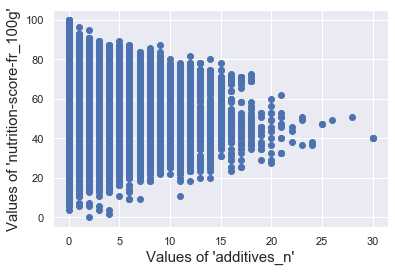

In [34]:
x = dataframe['additives_n']
y = dataframe['nutrition-score-fr_100g']

plt.xlabel("Values of 'additives_n'", fontsize=15)
plt.ylabel("Values of 'nutrition-score-fr_100g'", fontsize=15)

plt.scatter(x, y)

### Calcul du coefficient de corrélation linéaire (Pearson)

In [35]:
s1 = data_cleaned['additives_n']
s2 = data_cleaned['nutrition-score-fr_100g']

print("The Pearson linear correlation coefficient is: r = {}".format(s1.corr(s2, method='pearson')))

The Pearson linear correlation coefficient is: r = -0.1800573496677353


Nous obtenons un coefficient indiquant une corrélation négative très faible entre les deux variables.

# Partie 4 - Analyses multivariées

## 4.1 Corrélations bivariées avec pairplot de seaborn

### Échantillonnage
Pour éviter les erreurs d'insuffisance mémoire, nous échantillonnons le jeu de données.

In [36]:
# Sampling (1 out of 1'000)
data_sample = data_cleaned.sample(frac=0.001)

C:\Users\Lebrun\Anaconda3\envs\DS_projet3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Lebrun\Anaconda3\envs\DS_projet3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


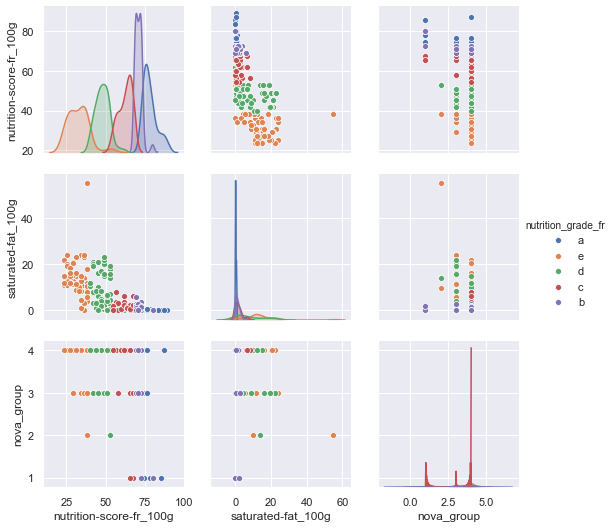

In [37]:
# Selecting some features for plotting
features = ['nutrition-score-fr_100g', 'saturated-fat_100g', 'nova_group', 'nutrition_grade_fr']
data_sample = data_sample[features]

# Selecting numeric features only
# data_sample = data_sample.select_dtypes(include='number')

# Plotting pairwise relationships in the dataset (numeric features)
sns.pairplot(data_sample, hue='nutrition_grade_fr')

## 4.2 Matrice de corrélation pour les variables quantitatives

In [38]:
def correlation_matrix(dataframe):
    """This function plots a correlation matrix using the seaborn package."""

    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    plt.title("Correlation matrix", fontsize=25)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

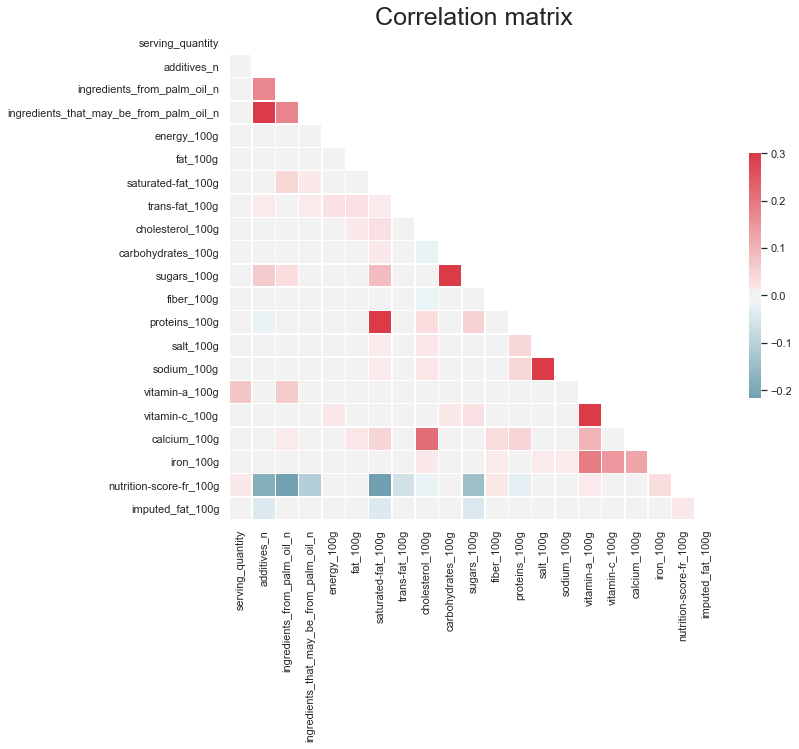

In [39]:
# filtering features to avoid to crunch the representation
dataframe = data_cleaned.drop(columns=['nutrition_grade_fr_encoded', 'nutrition-score-uk_100g'])

correlation_matrix(dataframe)

## 4.3 Vecteur de corrélation pour la variable 'nutrition-score-fr_100g'
Comme nous nous intéresssons spécifiquement aux corrélations de la variable de 'nutrition-score-fr_100g', nous allons projeter la matrice de corrélations sur cette seule variable afin d'obtenir un "vecteur de corrélation".

In [40]:
def correlation_vector(dataframe, feature):
    """This functions plots a correlation vector for a single feature."""

    # Load libraries
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white")

    # Compute the correlation matrix
    corr_matrix = dataframe.corr()

    # Keep only vector related to feature (pd.Series)
    corr_vector = corr_matrix[feature]
    
    # Remove the self-correlation case
    corr_vector = corr_vector.drop(feature)
    
    # Sort the pd.Series by descending order
    corr_vector = corr_vector.sort_values(ascending=False)

    # Convert the pd.Series to pd.DataFrame to fit requirements for sns.heatmap
    corr_vector = pd.DataFrame(corr_vector)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(3, 10))
    plt.title("Correlation vector\n" + feature + "\n", fontsize=25)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_vector, cmap=cmap, vmax=.3, center=0,
                square=False, linewidths=0.5, cbar_kws={"shrink": .5}, annot=True, fmt='1.3f', cbar=False)

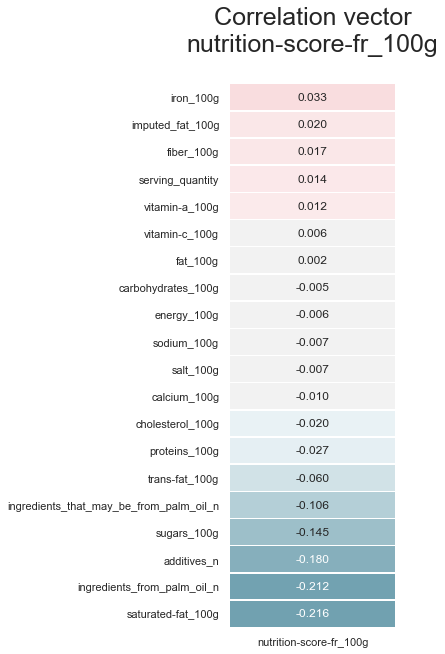

In [41]:
# filtering features to avoid to crunch the representation
dataframe = data_cleaned.drop(columns=['nutrition_grade_fr_encoded', 'nutrition-score-uk_100g'])
feature = 'nutrition-score-fr_100g'
correlation_vector(dataframe, feature)

En analysant ce vecteur de corrélation, nous pouvons constater que le score de nutrition rééchelonné ('nutrition-score-fr_100g') est positivement corrélé à :
* la présence de fer
* la présence de fibres
* la taille de la portion
* la présenec de vitamines A et C

Et négativement corrélé avec :
* la présence de graisses saturées
* la présence d'huile de palme
* la présence d'additifs
* la présence de sucres
* le niveau de transformation du produit ('nova_group')

Cela est cohérent avec le fait qu'un aliment est d'autant meilleur pour la santé que son score de nutrition est bas.

## 4.4 Correlations intégrant les variables catégorielles (dython)
La librairie dython (http://shakedzy.xyz/dython/) permet de calculer :
* pour les couples de variables quantitatives :
    * le coefficient de correlation de Pearson R 
    
    
* pour les couples de variables catégorielles :
    * le coefficient de Cramer V (symetrique)
    * le coefficient d'incertitude de Theil U (asymetrique)
    
    
* pour les couples de variables mixtes (quantitative + catégorielle) :
    * le ratio de correlation η (eta)

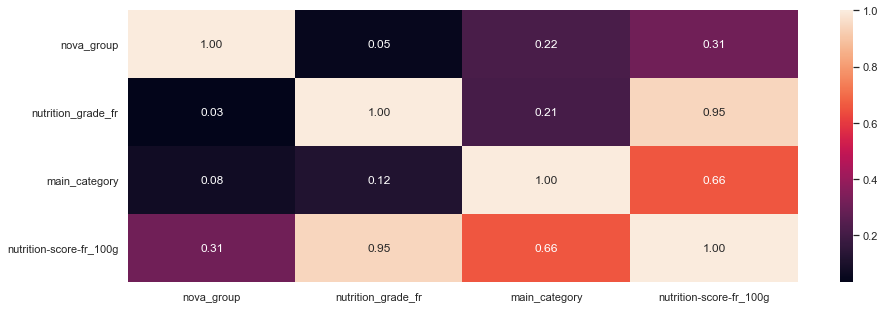

In [42]:
from dython.nominal import associations

nominal_columns = ['nova_group', 'nutrition_grade_fr', 'main_category']

# Have to drop NaN values to avoid errors
df_for_correlations = data_cleaned[['nova_group', 'nutrition_grade_fr', 'main_category', 'nutrition-score-fr_100g']].dropna()

# Calculate associations and display graph
associations(
    df_for_correlations,
    figsize=(15,5),
    theil_u=True, # asymetric measure of correlation for nominal feature
    nominal_columns=nominal_columns
)

Nous constatons que la variable 'nutrition-score-fr_100g' est très corrélée aux variables :
* 'nutrition_grade_fr' (ce qui était prévisiable, puisque ce n'est qu'un encodage "binning")
* 'main_category'

# Imputation des scores de nutrition manquant
Pour faire une imputation des scores de nutrition (variable 'nutrition-score-fr_100g'), nous pourrions faire un entraîner un modèle de ML. Néanmoins, pour faire simple, et en raison du grand nombre de données manquantes, nous allons procéder à une imputation par la moyenne du sous-groupe.

Nous allons définir une fonction dont l'objectif est d'imputer les valeurs manquantes en utilisant les valeurs d'autres lignes partageant certaines propriétés (nom de produit, catégorie de produit...).

In [43]:
def imputation(dataframe, feature, keys):
    """This function impute substitute values for missing values for a specific column (feature),
    based on other rows sharing some properties (values on other fields of subset).
    Also add a new feature to inform if the value was imputed.
    Does only handle numeric features yet."""
    
    # Identify NaN values pre-imputation
    mask_before = dataframe[feature].isnull()
    
    # Copying the dataframe to avoid manipulating a slice
    result = dataframe.copy()
    
    # Initialize column for imputed values if doesn't exist
    if "imputed_" + feature not in result.columns:
        result["imputed_" + feature] = False
    
    # Iterating on each feature in the subset
    for column in keys:
        
        # Grouping the DataFrame on the column's value, sort=False to speed-up
        grouped = dataframe.groupby(column, sort=False)
        
        # Computing the mean of feature for each group
        means_of_group = grouped[feature].transform('mean') # to adapt for object and categorical dtypes features
        
        # Filling missing values with the mean of each group
        result[feature].fillna(value=means_of_group, axis=0, inplace=True)
    
    # Identify NaN values post-imputation
    mask_after = result[feature].isnull()
    
    # Values imputed : boolean symetric difference
    mask_imputed = mask_after ^ mask_before
    
    # Update the column to inform that the feature was imputed
    result["imputed_" + feature][mask_imputed] = True # raise a SettingWithCopyWarning
    
    return result

Nous calculons le taux de remplissage de la colonne 'nutrition-score-fr_100g' avant l'imputation.

In [44]:
dataframe = data_cleaned
feature = 'nutrition-score-fr_100g'
feature_filling_rate(dataframe, feature)

The filling rate of the column 'nutrition-score-fr_100g' is: 27.38%


0.273802322610251

In [45]:
# Ordered list of the keys used to impute the feature
keys = [
    'product_name',
    'categories',
    'main_category'
]

data_cleaned = imputation(dataframe, feature, keys)

C:\Users\Lebrun\Anaconda3\envs\DS_projet3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
data_cleaned.head(3)

,code,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,labels,labels_tags,labels_en,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,serving_size,serving_quantity,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,nova_group,pnns_groups_1,pnns_groups_2,main_category,main_category_en,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,imputed_fat_100g,nutrition_grade_fr_encoded,imputed_nutrition-score-fr_100g
0,0000000000017,Vitória crackers,None,None,None,None,None,None,None,None,None,None,None,None,None,None,France,en:france,France,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,unknown,unknown,None,None,1569.0,7.000000,3.08,NaN,NaN,70.099998,15.0,NaN,7.8,1.40000,0.551181,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
1,0000000000031,Cacao,None,130 g,None,None,None,None,None,None,None,None,None,None,None,None,France,en:france,France,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,unknown,unknown,None,None,1100.0,16.344444,1.90,NaN,NaN,16.000000,4.2,NaN,5.6,0.52832,0.208000,NaN,NaN,NaN,NaN,48.051949,NaN,True,NaN,True
2,0000000000123,Sauce Sweety chili 0%,None,None,None,None,None,None,None,None,None,None,None,None,None,None,France,en:france,France,None,None,NaN,NaN,None,None,None,NaN,NaN,None,NaN,unknown,unknown,None,None,88.0,0.000000,0.00,NaN,NaN,4.800000,0.4,NaN,0.2,2.04000,0.803150,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False


Nous recalculons le taux de remplissage de la colonne 'nutrition-score-fr_100g' pour constater les effets de l'imputation.

In [47]:
dataframe = data_cleaned
feature_filling_rate(dataframe, feature)

The filling rate of the column 'nutrition-score-fr_100g' is: 43.65%


0.43646977842903106

# Sauvegarde des données pour l'application
Nous ne conservons que les produits :
* dont le code barre et le nom de produit sont renseignés
* dont le score de nutrition est renseigné ou a pu être imputé
* commercialisés en France

### Filtrage des produits distribués en France

In [48]:
def research_df(dataframe, string, axis=0, case=False):
    '''This functions search for a specified string into the cells of a pd.DataFrame.
    If axis=0 (default), returns a view of rows containing the string.
    If axis=1, returns a view of columns containing the string. (NOT IMPLEMENTED YET)
    case=False : non case-sensitive'''
    
    # Getting the list of the columns name
    columns = list(dataframe)
    
    # Initialize a mask for rows containing the string
    index = dataframe.index
    mask_global = pd.Series(False, index)
    
    # Selecting columns with object dtype (to use the .str selector)
    str_columns = dataframe.select_dtypes(include='object').columns # index object
    
    # Iterating upon columns
    for column in str_columns:
        
        # Get a series giving the rows containing the string for this column
        mask = dataframe[column].str.contains(string, case=case)
        
        # Aggregate the rows containing the string with previous ones
        mask_global = mask | mask_global # logical "OR"
    
    # Return a view of dataframe with only rows containing the string
    return dataframe[mask_global]

In [49]:
dataframe = data_cleaned
string = 'France'

len(research_df(dataframe, string))

27616

Seuls 28'000 produits possèdent le mot 'France' dans l'un de leurs champs. Ce filtrage élimine presque plus de 90% des produits de la base de données. Nous renonçons à l'effectuer car trop peu de produits sont correctement renseignés en ce qui concerne la distribution.

### Conservation des seules colonnes utiles et sauvegarde finale

In [50]:
# Keeping only useful features for application
key_features = ['nutrition-score-fr_100g',
                'product_name',
                'code']

secondary_features = ['saturated-fat_100g',
            'ingredients_from_palm_oil_n',
            'additives_n',
            'sugars_100g',
            'imputed_nutrition-score-fr_100g',]

# Concatenating the 2 lists of features
features = key_features + secondary_features

final_data = data_cleaned[features]

# Droping rows with empty values in for key features
final_data = final_data.dropna(subset=key_features)

# Print the number of rows in the final database
print("There are {} products in the final database.".format(final_data.shape[0]))

# Set barcode as index to save space
final_data = final_data.set_index('code')

# Visualize the few last lines
final_data.tail(3)

There are 334802 products in the final database.


,nutrition-score-fr_100g,product_name,saturated-fat_100g,ingredients_from_palm_oil_n,additives_n,sugars_100g,imputed_nutrition-score-fr_100g
code,,,,,,,
8713445020121,73.246750,Farine de riz,0.600000,0.0,0.0,0.800000,True
8715415457999,25.454546,Vollmilch Schokoladen Lutscher-Stern mit bunte...,19.700001,0.0,3.0,53.700001,False
8718452146833,72.727272,Biologische volle melk lang hoodbaar,2.200000,NaN,NaN,4.500000,False


In [51]:
# Save as .csv file
final_data.to_csv("p3_finaldata.csv")

# Print the size of the final database
import os
print("The size of the final database is: {} bytes.".format(os.path.getsize('p3_finaldata.csv')))

The size of the final database is: 28026294 bytes.


La base de données finale pèse moins de 30Mo et compte plus de 330'000 produits.

# Synthèse des faits pertinents pour l’application

1. Amélioration de la lisibilité du Nutri-Score par ré-étalonnage
    * Entre 0 et 100
    * 0 : mauvais ; 100 : bon


2. **Facteurs principaux** du Nutri-Score :
    * Facteurs négatifs :
        * acides gras saturés
        * huile de palme
        * additifs
        * sucres
    * Facteurs positif :
        * fer
        * fibres
        * vitamines


3. Nombre de produits pris en charge : **+300'000 produits**
    * Impossibilité de filtrer les produits distribués en France
    * Imputation du Nutri-Score sur la base :
        * code-barre (fusion des doublons)
        * nom de produit, catégories de produit…      
    * Améliorations possibles :
        * prise en charge de l'EAN8 (8 chiffres, pour les petits emballages)
        * imputation du Nutri-Score :
            * grâce à la formule du Nutri-Score
   * grâce à des algorithmes d'apprentissage automatique


4. Taille de la base de données (**< 30 Mo**) :
    * Yuka : 55 Mo + connexion requise
    * Application autonome
    * Transparence pour l'utilisateur des Nutri-Score imputés
    * Améliorations possibles
        * fichier binaire et/ou compressé
        * stocker la note (a-e) plutôt que le score (0-100)